In this note bookbook, we will make a few changes to the workflow by referring to the one of the available kernels.

Changes:
- Instead of predicting the ghrapheme root we are predicting the 3rd of the 3 output classes: consonant-diacritic

In [1]:
%matplotlib inline 
# If we don't do this then image will open as pop-up and not in notebook

In [2]:
import pyarrow.parquet as pq 
import pandas as pd
import numpy as np
from PIL import Image as im
import matplotlib as plt
from matplotlib.pyplot import imshow

In [3]:
from skimage import io

In [4]:
import wget
import time
import os
import copy

In [5]:
!ls -l ~/datasets/bengali-ai/

total 9126408
-rw-r--r-- 1 ubuntu ubuntu 4161805187 Jan 16 23:18 bengaliai-cv19.zip
-rw-r--r-- 1 ubuntu ubuntu       4830 Dec 19 18:22 class_map.csv
-rw-r--r-- 1 ubuntu ubuntu        944 Dec 19 18:22 sample_submission.csv
-rw-r--r-- 1 ubuntu ubuntu       1742 Dec 19 18:22 test.csv
-rw-r--r-- 1 ubuntu ubuntu    9903859 Dec 19 18:22 test_image_data_0.parquet
-rw-r--r-- 1 ubuntu ubuntu   10003997 Dec 19 18:22 test_image_data_1.parquet
-rw-r--r-- 1 ubuntu ubuntu    9996850 Dec 19 18:22 test_image_data_2.parquet
-rw-r--r-- 1 ubuntu ubuntu    9995989 Dec 19 18:22 test_image_data_3.parquet
-rw-r--r-- 1 ubuntu ubuntu    6281787 Dec 19 18:22 train.csv
-rw-r--r-- 1 ubuntu ubuntu 1285682162 Dec 19 18:22 train_image_data_0.parquet
-rw-r--r-- 1 ubuntu ubuntu 1278647926 Dec 19 18:25 train_image_data_1.parquet
-rw-r--r-- 1 ubuntu ubuntu 1287469785 Dec 19 18:29 train_image_data_2.parquet
-rw-r--r-- 1 ubuntu ubuntu 1285595675 Dec 19 18:32 train_image_data_3.parquet
drwxr-xr-x 8 ubuntu ubuntu       4096

### The Train Files

In [6]:
# Training label files
train_labels = pd.read_csv("/home/ubuntu/datasets/bengali-ai/train.csv")

In [7]:
train_labels.shape

(200840, 5)

In [8]:
train_labels.head(5)

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [10]:
train_labels['consonant_diacritic'].max(), train_labels['consonant_diacritic'].min(), train_labels['consonant_diacritic'].unique()

(6, 0, array([5, 0, 2, 1, 3, 4, 6]))

In [11]:
!ls -l /home/ubuntu/datasets/bengali-ai/

total 9126408
-rw-r--r-- 1 ubuntu ubuntu 4161805187 Jan 16 23:18 bengaliai-cv19.zip
-rw-r--r-- 1 ubuntu ubuntu       4830 Dec 19 18:22 class_map.csv
-rw-r--r-- 1 ubuntu ubuntu        944 Dec 19 18:22 sample_submission.csv
-rw-r--r-- 1 ubuntu ubuntu       1742 Dec 19 18:22 test.csv
-rw-r--r-- 1 ubuntu ubuntu    9903859 Dec 19 18:22 test_image_data_0.parquet
-rw-r--r-- 1 ubuntu ubuntu   10003997 Dec 19 18:22 test_image_data_1.parquet
-rw-r--r-- 1 ubuntu ubuntu    9996850 Dec 19 18:22 test_image_data_2.parquet
-rw-r--r-- 1 ubuntu ubuntu    9995989 Dec 19 18:22 test_image_data_3.parquet
-rw-r--r-- 1 ubuntu ubuntu    6281787 Dec 19 18:22 train.csv
-rw-r--r-- 1 ubuntu ubuntu 1285682162 Dec 19 18:22 train_image_data_0.parquet
-rw-r--r-- 1 ubuntu ubuntu 1278647926 Dec 19 18:25 train_image_data_1.parquet
-rw-r--r-- 1 ubuntu ubuntu 1287469785 Dec 19 18:29 train_image_data_2.parquet
-rw-r--r-- 1 ubuntu ubuntu 1285595675 Dec 19 18:32 train_image_data_3.parquet
drwxr-xr-x 8 ubuntu ubuntu       4096

### Getting the data ready

In [12]:
# PyTorch databuild libraries and modules
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [13]:
import torch
from torchvision import datasets, models, transforms

In [15]:
class BengaliCharacterDataset(Dataset):
    """Bengali language handwritten character dataset."""
    
    def __init__(self, root_dir, transform=None):
        """
        Args:
            dataframe (string): Dataframe of parquet dataset with image data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):        
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_id = 'Train_'+str(idx)
        img_name = image_id+'.png'
        
        # columns from class_map: image_id, grapheme_root, vowel_diacritic, consonant_diacritic, grapheme
        img_label = train_labels.loc[train_labels['image_id'] == image_id, 'consonant_diacritic'].to_numpy()[0] 
        # added to.numpy()[0] to remove index number
                
        img_path = os.path.join(self.root_dir,img_name)
        image = io.imread(img_path)

        # sample = {'image': img_data, 'img_label': img_label}
        
        if self.transform:
            image = self.transform(im.fromarray(image).convert('RGB'))
            # sample = {'img_label': img_label, 'image': img_data}

        return image, img_label

In [16]:
# Now let's create a PyTorch Dataset object with transformations
transformed_dataset = BengaliCharacterDataset(root_dir='/home/ubuntu/datasets/bengali-ai/training_images/train_224by224//',
                                           transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                               transforms.Normalize([0.0692, 0.0692, 0.0692], [0.2051, 0.2051, 0.2051])
                                           ]))

In [17]:
tt = transformed_dataset.__getitem__(65)

In [18]:
len(tt), tt

(2, (tensor([[[4.4427, 4.4809, 4.4236,  ..., 4.4809, 4.4809, 4.4618],
           [4.4618, 4.4809, 4.4618,  ..., 4.4809, 4.4618, 4.4618],
           [4.5000, 4.5000, 4.5000,  ..., 4.4618, 4.4618, 4.4809],
           ...,
           [4.4618, 4.5000, 4.5000,  ..., 4.4809, 4.4809, 4.4809],
           [4.4618, 4.4809, 4.4809,  ..., 4.4618, 4.4618, 4.4809],
           [4.4618, 4.4618, 4.4809,  ..., 4.4618, 4.4618, 4.4809]],
  
          [[4.4427, 4.4809, 4.4236,  ..., 4.4809, 4.4809, 4.4618],
           [4.4618, 4.4809, 4.4618,  ..., 4.4809, 4.4618, 4.4618],
           [4.5000, 4.5000, 4.5000,  ..., 4.4618, 4.4618, 4.4809],
           ...,
           [4.4618, 4.5000, 4.5000,  ..., 4.4809, 4.4809, 4.4809],
           [4.4618, 4.4809, 4.4809,  ..., 4.4618, 4.4618, 4.4809],
           [4.4618, 4.4618, 4.4809,  ..., 4.4618, 4.4618, 4.4809]],
  
          [[4.4427, 4.4809, 4.4236,  ..., 4.4809, 4.4809, 4.4618],
           [4.4618, 4.4809, 4.4618,  ..., 4.4809, 4.4618, 4.4618],
           [4.5000,

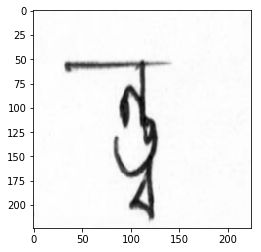

In [21]:
# to_pil = transforms.ToPILImage() 
imshow(tt[0][0], cmap='gray')

### Creating a validation dataset from training data

In [22]:
train_size = int(0.8 * len(transformed_dataset))
val_size = len(transformed_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, val_size])

In [23]:
len(train_dataset), len(val_dataset)

(160672, 40168)

In [24]:
model_data = {}
model_data['train'] = train_dataset
model_data['val'] = val_dataset

### Getting the dataloader ready

Within a Python process, the Global Interpreter Lock (GIL) prevents true fully parallelizing Python code across threads. To avoid blocking computation code with data loading, PyTorch provides an easy switch to perform multi-process data loading by simply setting the argument num_workers to a positive integer.

In [25]:
dataloaders = {x: DataLoader(model_data[x], 
                             batch_size=16,
                             #shuffle=True, 
                             num_workers=4)
              for x in ['train', 'val']}

In [26]:
len(dataloaders['train'].dataset), len(dataloaders['val'].dataset), len(dataloaders['train']), len(dataloaders['val'])

(160672, 40168, 10042, 2511)

In [27]:
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

In [28]:
# class_names = dataloaders['train'].dataset.
dataset_sizes['train'], dataset_sizes['val']

(160672, 40168)

In [29]:
len(dataloaders['train'].dataset), len(dataloaders['val'].dataset)

(160672, 40168)

In [30]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            start_time = time.time()
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            end_time = time.time()
            hours, rem = divmod(end_time-start_time, 3600)
            minutes, seconds = divmod(rem, 60)
            print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [31]:
# PyTorch libraries and modules
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.optim as optim
import torch

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [33]:
# Load a pretrained model and reset final fully connected layer.

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 7 for consonant diacritic.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 7)

# Ensuring the model is using GPU
model_ft = model_ft.to(device)

# As we have two classes (0 or 1) we will use cross-entropy as criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [34]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 0.1758 Acc: 0.9456
00:17:08.38
val Loss: 0.1115 Acc: 0.9646
00:01:57.91

Epoch 1/14
----------
train Loss: 0.0734 Acc: 0.9785
00:17:09.12
val Loss: 0.0930 Acc: 0.9746
00:01:58.05

Epoch 2/14
----------
train Loss: 0.0434 Acc: 0.9870
00:17:09.61
val Loss: 0.0984 Acc: 0.9748
00:01:57.75

Epoch 3/14
----------
train Loss: 0.0319 Acc: 0.9899
00:17:08.25
val Loss: 0.1063 Acc: 0.9722
00:01:58.14

Epoch 4/14
----------
train Loss: 0.0234 Acc: 0.9923
00:17:09.30
val Loss: 0.1180 Acc: 0.9729
00:01:57.74

Epoch 5/14
----------
train Loss: 0.0199 Acc: 0.9933
00:17:11.34
val Loss: 0.1145 Acc: 0.9763
00:01:58.10

Epoch 6/14
----------
train Loss: 0.0160 Acc: 0.9945
00:17:11.07
val Loss: 0.1157 Acc: 0.9756
00:01:58.11

Epoch 7/14
----------
train Loss: 0.0114 Acc: 0.9962
00:17:09.23
val Loss: 0.1158 Acc: 0.9774
00:01:58.19

Epoch 8/14
----------
train Loss: 0.0039 Acc: 0.9988
00:17:10.14
val Loss: 0.1046 Acc: 0.9812
00:01:57.69

Epoch 9/14
----------
train Loss: 0.0

In [36]:
torch.save(model_ft, 'consonant-diacritic-base.pth')

In [37]:
model_ft2 = torch.load('consonant-diacritic-base.pth')